# **Modelos Benchmarks**

In [1]:
# Librerias Importadas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera



Se importa la base de datos y definimos las variables predictoras y la variable respuesta. Luego, dividimos los datos para formar el conjunto de entrenamiento y el de prueba.

In [3]:
# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Files\Rentabilidad_filtrado.csv")

# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "TIPO_PARTICIPACION", "PRECIERRE_FONDO_DIA_T",  "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]



# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## **Funciones**

Creamos funciones clave para optimizar la creación de graficos y el calculo de metricas para los respectivos modelos de regresión.

In [4]:
def analizar_residuos(residuos, ljung_box_p_value):
    """
    Aplica transformaciones a los residuos y genera gráficos.
    
    Parámetros:
    - residuos: array-like, residuos del modelo.
    - ljung_box_p_value: float, p-valor de la prueba de Ljung-Box.
    """
    # Aplicar transformaciones
    residuos_esc = (residuos - np.mean(residuos)) / np.std(residuos)  # Escalar residuos
    residuos_log = np.log1p(np.abs(residuos)) * np.sign(residuos)  # Log-transformación
    
    # Crear figura con dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 📊 Gráfico 1: ACF de los residuos escalados
    plot_acf(residuos_esc, ax=axes[0], lags=30)
    axes[0].set_title(f"ACF de los Residuos Escalados\nLjung-Box: {ljung_box_p_value:.4f}")
    
    # 📊 Gráfico 2: Histograma de los residuos log-transformados
    sns.histplot(residuos_log, bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Histograma de los Residuos Log-transformados")
    axes[1].set_xlabel("Valor del Residuo Transformado")
    
    # Ajustar diseño y mostrar gráficos
    plt.tight_layout()
    plt.show()

In [5]:
def scatter_real_vs_pred(y_test, y_test_pred):
    """
    Crea un gráfico de dispersión comparando los valores reales vs los predichos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
    
    # Agregar línea de referencia y etiquetas
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Línea Ideal (y=x)")
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Predicho")
    plt.title("Dispersión: Real vs Predicho")
    plt.legend()
    
    # Mostrar gráfico
    plt.show()

In [6]:
def calcular_metricas(y_test, y_test_pred):
    """
    Calcula métricas de error y realiza pruebas estadísticas sobre los residuos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    
    Retorna:
    - DataFrame con métricas MAPE, RMSE, R², Ljung-Box p-value y Jarque-Bera p-value.
    - Residuos calculados.
    """
    # Calcular métricas
    mae = mean_absolute_percentage_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    
    # Residuos
    residuos = y_test - y_test_pred
    
    # Pruebas estadísticas
    ljung_box_p_value = acorr_ljungbox(residuos, lags=[10]).iloc[0, 1]
    jarque_bera_p_value = jarque_bera(residuos)[1]
    
    # Crear DataFrame con resultados
    resultados = pd.DataFrame({
        "MAPE": [mae],
        "RMSE": [rmse],
        "R²": [r2],
        "Ljung-Box p-value": [ljung_box_p_value],
        "Jarque-Bera p-value": [jarque_bera_p_value]
    })
    
    return resultados, residuos, ljung_box_p_value

## **Regresión Lineal**

In [47]:

st = time.time()
lr = LinearRegression().fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Tiempo de entrenamiento: 0.19 segundos
Training set score: 0.72
Test set score: 0.69


La diferencia entre entrenamiento y prueba es pequeña, lo que sugiere que el modelo no está sobreajustando.

In [48]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [49]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  2.699087e+09  2.431247e+10  0.694025           0.717177   

   Jarque-Bera p-value  
0                  0.0  


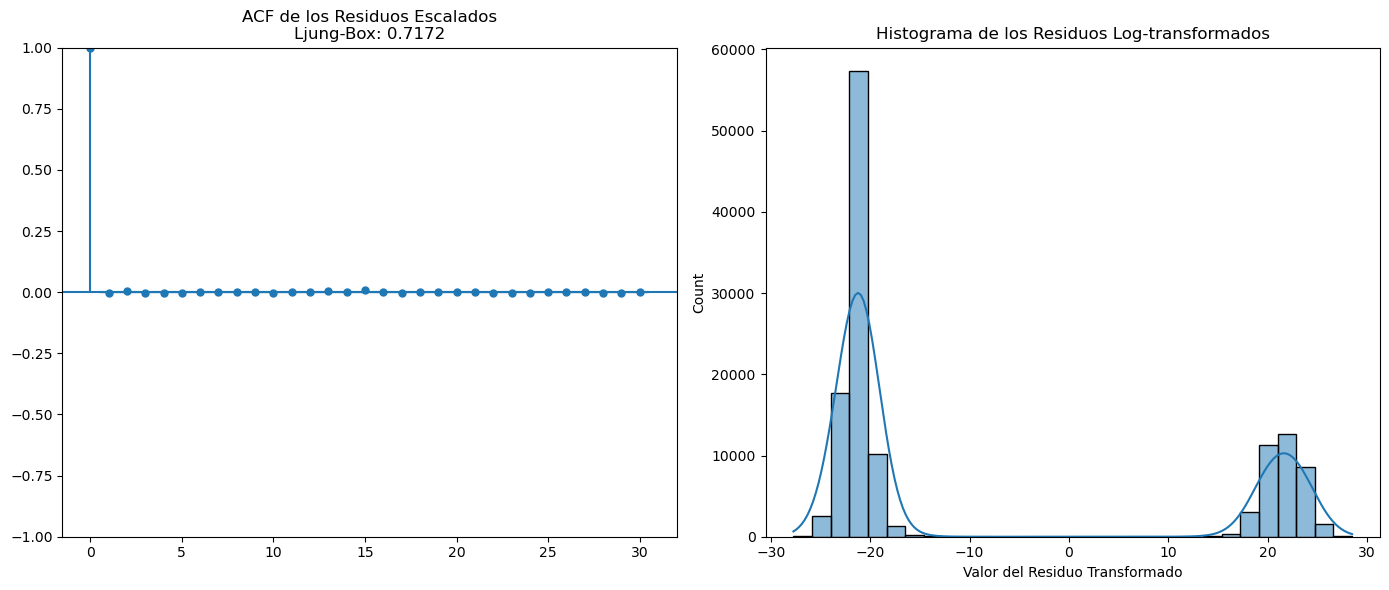

In [10]:
analizar_residuos(residuos, ljung_box_p_value)

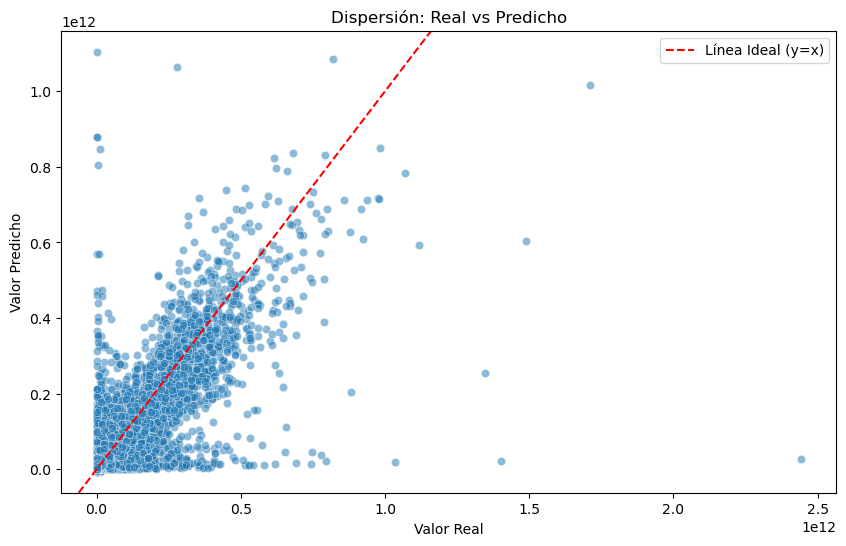

In [11]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Regresión de Ridge**

In [36]:
st = time.time()
ridge = Ridge().fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Tiempo de entrenamiento: 0.18 segundos
Training set score: 0.72
Test set score: 0.69


In [13]:
y_test_pred = ridge.predict(X_test)

resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)


           MAPE          RMSE        R²  Ljung-Box p-value  \
0  2.699118e+09  2.431247e+10  0.694025           0.717176   

   Jarque-Bera p-value  
0                  0.0  


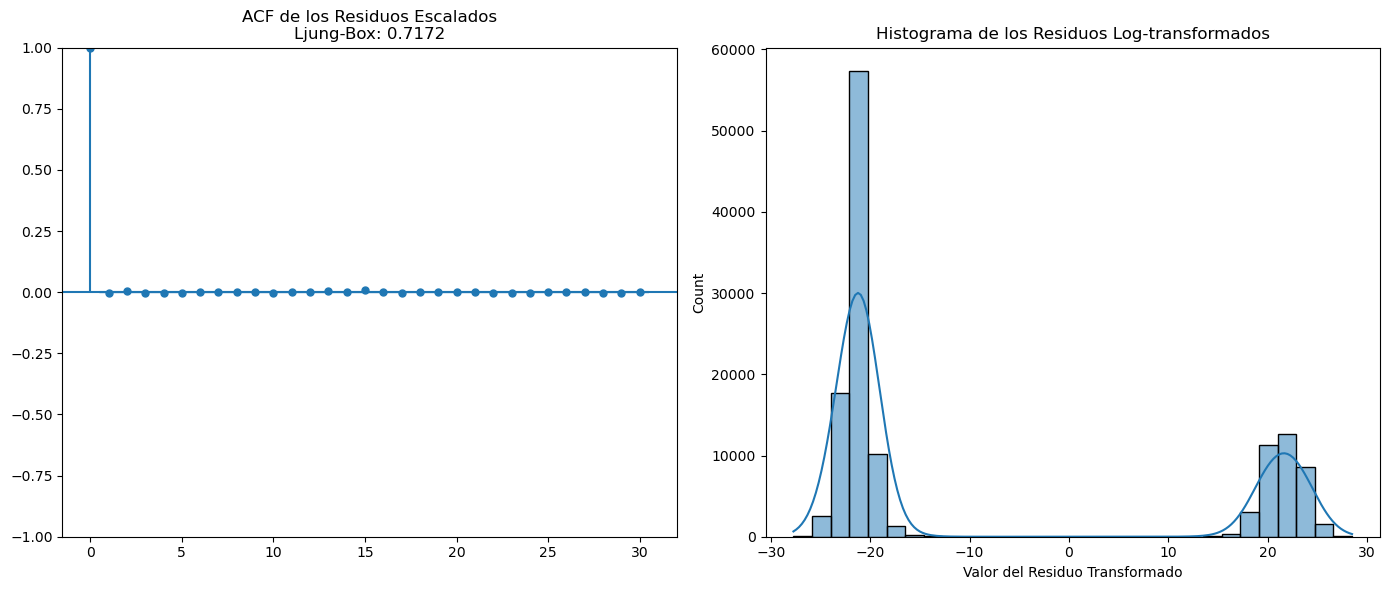

In [14]:
analizar_residuos(residuos, ljung_box_p_value)

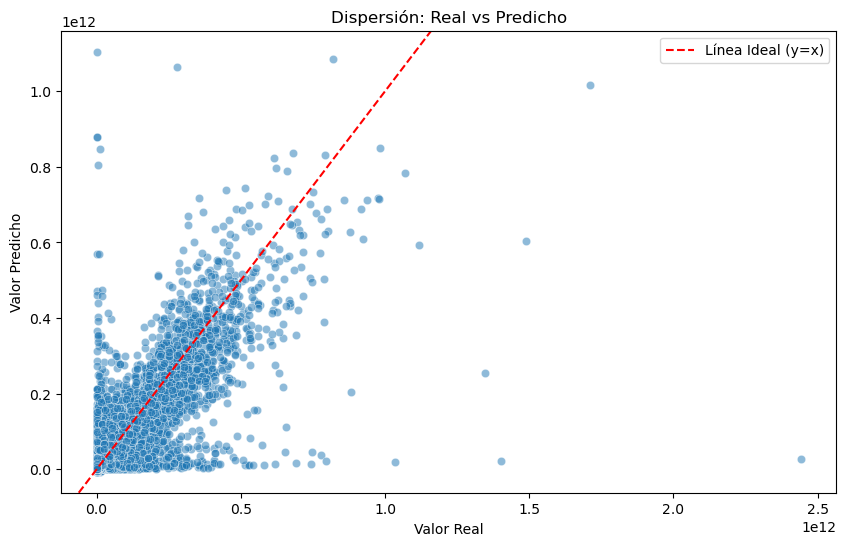

In [15]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Lasso**

In [37]:
st = time.time()
lasso = Lasso().fit(X_train, y_train)
et = time.time()    
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Tiempo de entrenamiento: 7.94 segundos
Training set score: 0.72
Test set score: 0.69
Number of features used: 5


In [17]:

y_test_pred = lasso.predict(X_test)

In [18]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  2.699087e+09  2.431247e+10  0.694025           0.717177   

   Jarque-Bera p-value  
0                  0.0  


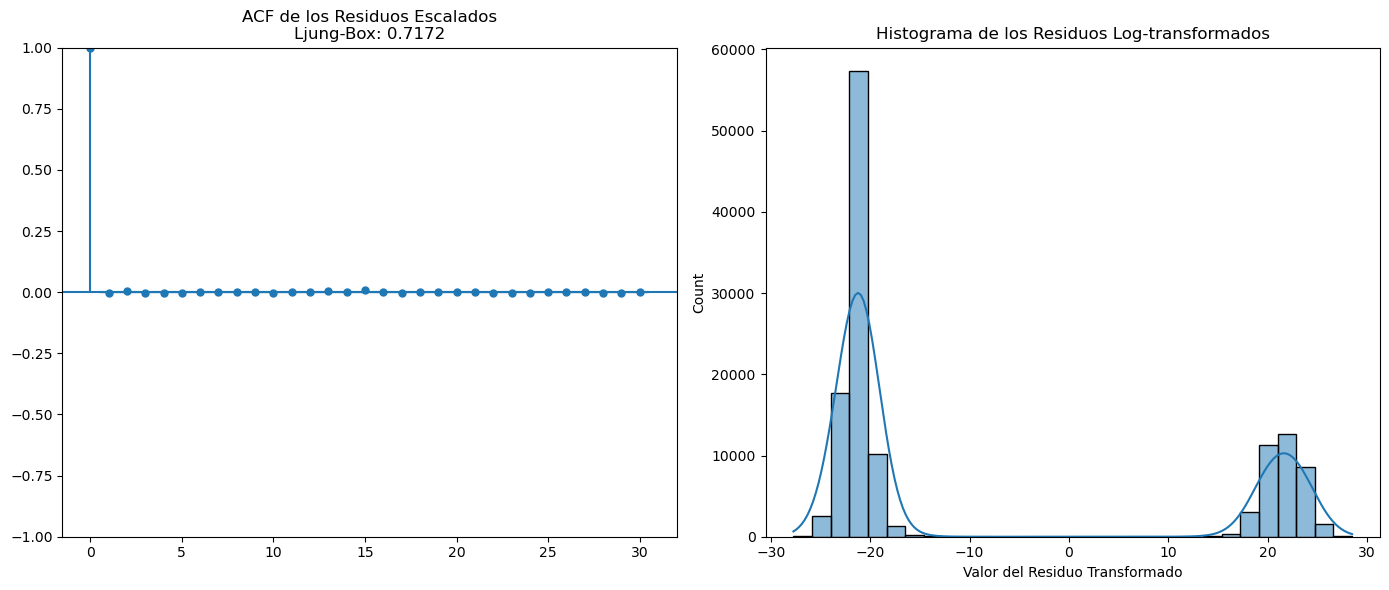

In [19]:
analizar_residuos(residuos, ljung_box_p_value)

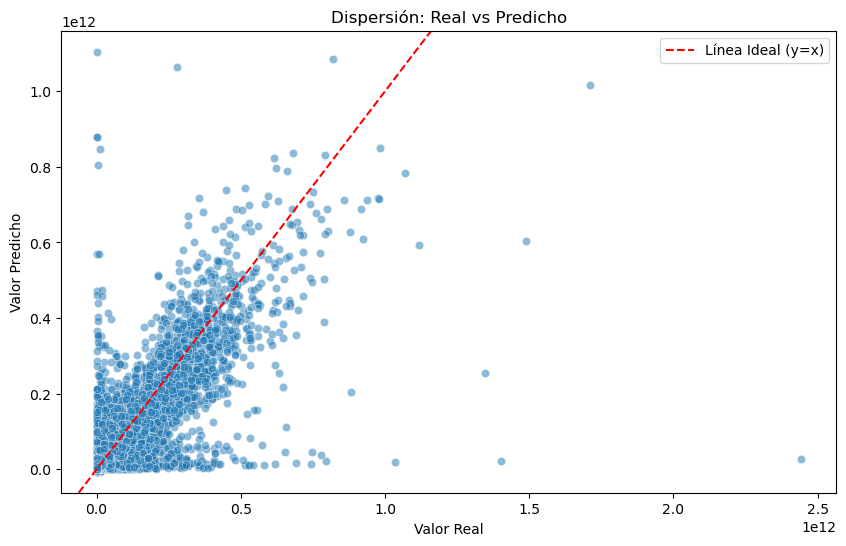

In [20]:
scatter_real_vs_pred(y_test, y_test_pred)

## **KNN**

In [38]:
KNN = KNeighborsRegressor(n_neighbors=5, weights='uniform')
st = time.time()    
    # Entrenar el modelo
KNN.fit(X_train, y_train)
et = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
    # Predicciones
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

Tiempo de entrenamiento: 1.47 segundos
R² en entrenamiento: 0.7846
R² en prueba: 0.7340


### Metricas y Graficos

In [22]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.148941e+09  2.266814e+10  0.734013           0.696304   

   Jarque-Bera p-value  
0                  0.0  


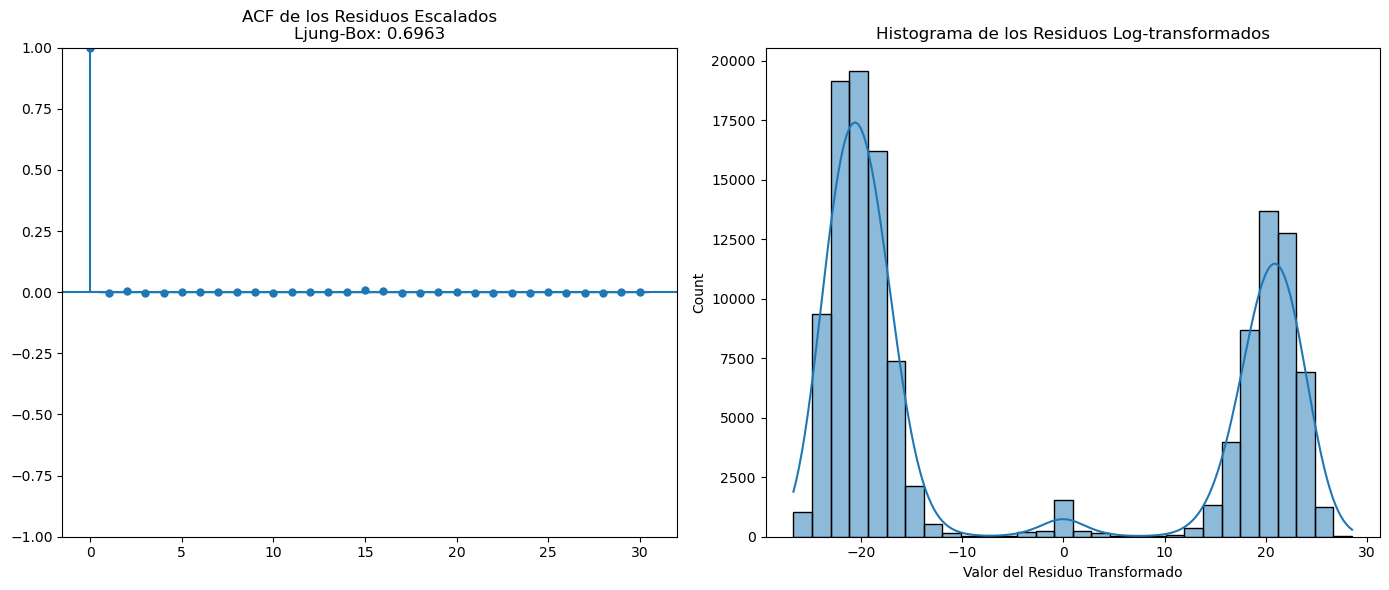

In [23]:
analizar_residuos(residuos, ljung_box_p_value)

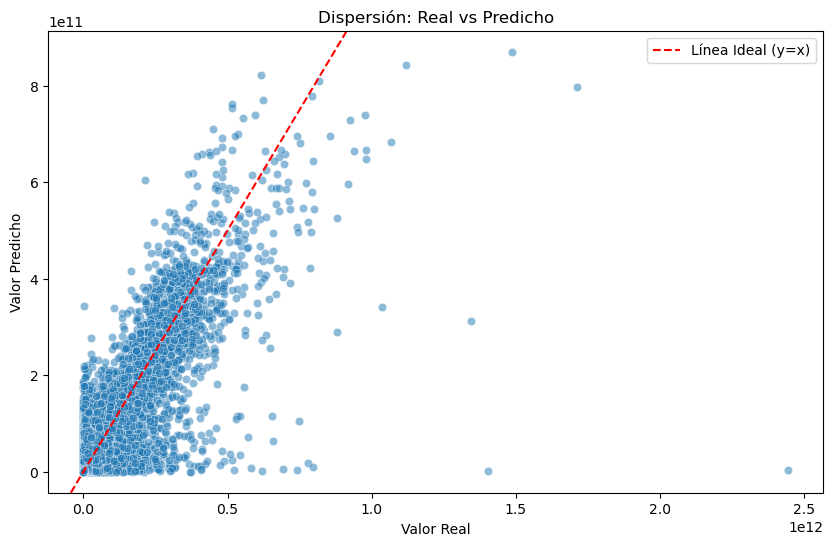

In [24]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Random Forest**

In [40]:
RANFOR = RandomForestRegressor(n_estimators=300, max_depth=6, max_features='sqrt', random_state=42)
st = time.time()
RANFOR.fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))

# Predicciones
y_train_pred = RANFOR.predict(X_train)
y_test_pred = RANFOR.predict(X_test)

    # Imprimir R²
print(f'R² en entrenamiento: {r2_score(y_train, y_train_pred):.4f}')
print(f'R² en prueba: {r2_score(y_test, y_test_pred):.4f}')

Tiempo de entrenamiento: 203.52 segundos
R² en entrenamiento: 0.7627
R² en prueba: 0.7445


In [41]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  3.507639e+09  2.221618e+10  0.744514           0.170406   

   Jarque-Bera p-value  
0                  0.0  


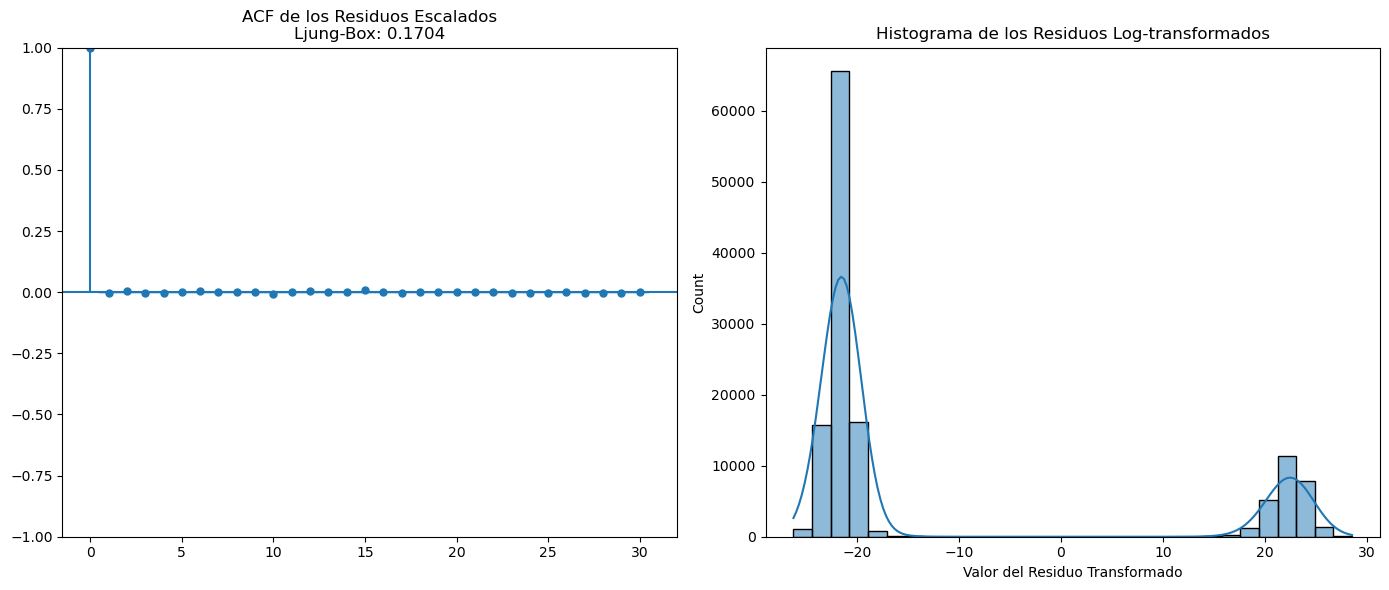

In [42]:
analizar_residuos(residuos, ljung_box_p_value)

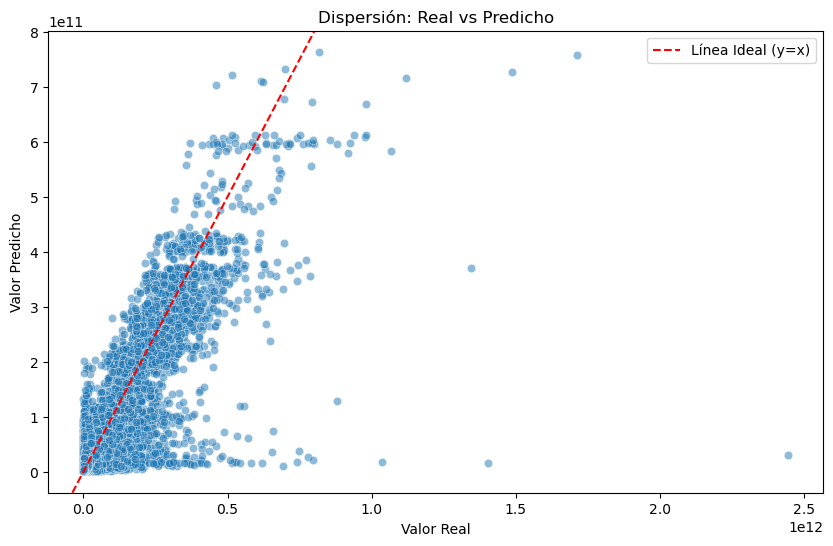

In [43]:
scatter_real_vs_pred(y_test, y_test_pred)

## **XGBoost**

In [44]:
XGB = XGBRegressor(
    n_estimators=500,        # Aumentar número de árboles
    learning_rate=0.05,      # Reducir tasa de aprendizaje
    max_depth=4,             # Menos profundidad para evitar sobreajuste
    min_child_weight=5,      # Aumentar para evitar divisiones innecesarias
    subsample=0.8,           # Muestra aleatoria del 80% de los datos en cada árbol
    colsample_bytree=0.8,    # Selección aleatoria del 80% de las características
    reg_alpha=0.1,           # Regularización L1 (Lasso)
    reg_lambda=1,            # Regularización L2 (Ridge)
    random_state=42,
    n_jobs=-1       # Métrica de evaluación
)

st = time.time()
    # Entrenar el modelo
XGB.fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
    
    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

Tiempo de entrenamiento: 9.98 segundos
R² en entrenamiento: 0.7790
R² en prueba: 0.7096


In [46]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE       R²  Ljung-Box p-value  Jarque-Bera p-value
0  1.219346e+09  2.368683e+10  0.70957           0.637155                  0.0


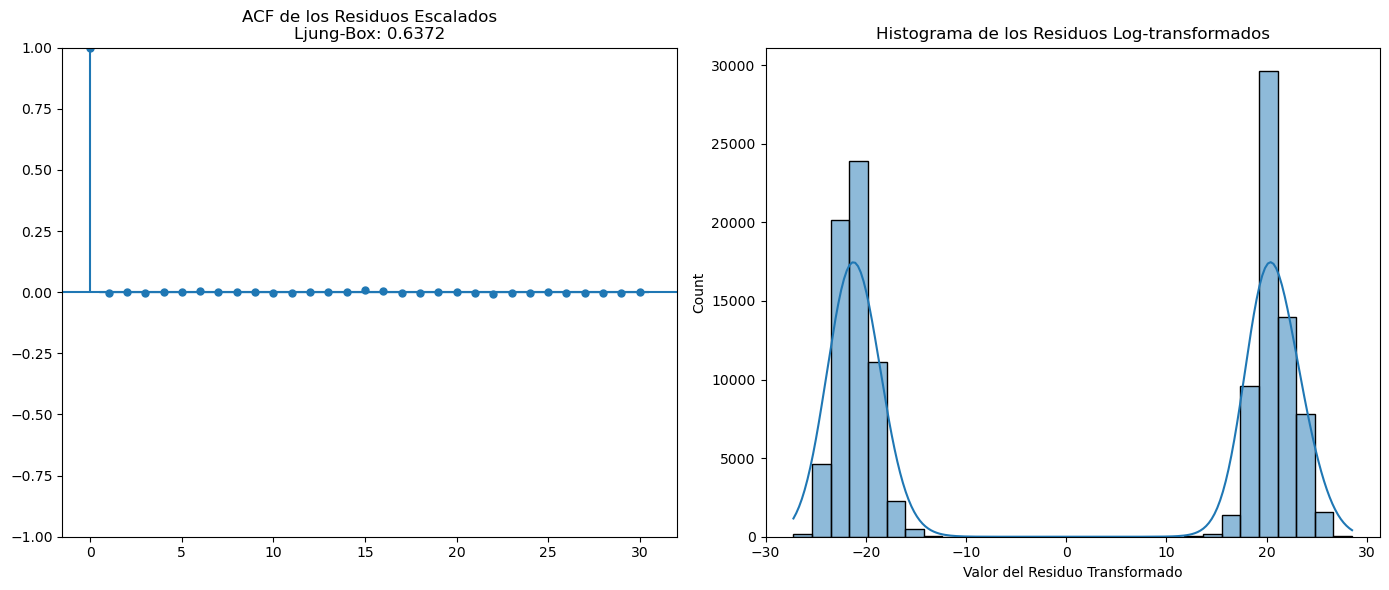

In [32]:
analizar_residuos(residuos, ljung_box_p_value)

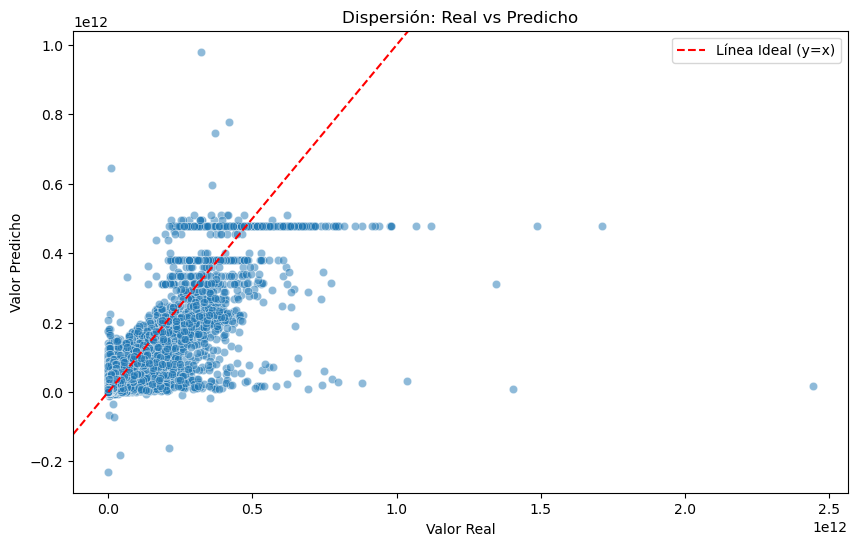

In [33]:
scatter_real_vs_pred(y_test, y_test_pred)